In [1]:

import json
import os
import csv
import re

import math
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf       # for ANOVA
import statsmodels.stats.multicomp as multi # for post hoc test 
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import preprocessing
import scipy.spatial.distance as distance
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.stats import skew
from matplotlib.backends.backend_pdf import PdfPages

from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
import math
import sys
import subprocess

# Import analysis Scripts
import nbimporter
import Analysis_Util as analysis_util

C:\Users\j3hartma\Anaconda3\envs\AEAnalysis\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Importing Jupyter notebook from Analysis_Util.ipynb


In [2]:
pd.set_option('display.max_columns', None)  
sns.set()
sns.set_style("whitegrid")

In [3]:
# Win
distalLocationAll = r'F:\GIT_DIR_3\cs846-project\data-new.csv'

In [3]:
# Win 2
distalLocationAll = r'D:\GIT_DIR\CS846-Project\data-new.csv'

In [3]:
# OSX
distalLocationAll = r'/Volumes/Second_HD/GIT_DIR_2/cs846-Project/data-new.csv'

# Data Analysis

In [4]:
# Load data
alldata = pd.read_csv(distalLocationAll)

In [5]:
# Drop first column
alldata = alldata.drop(alldata.columns[0], axis=1)

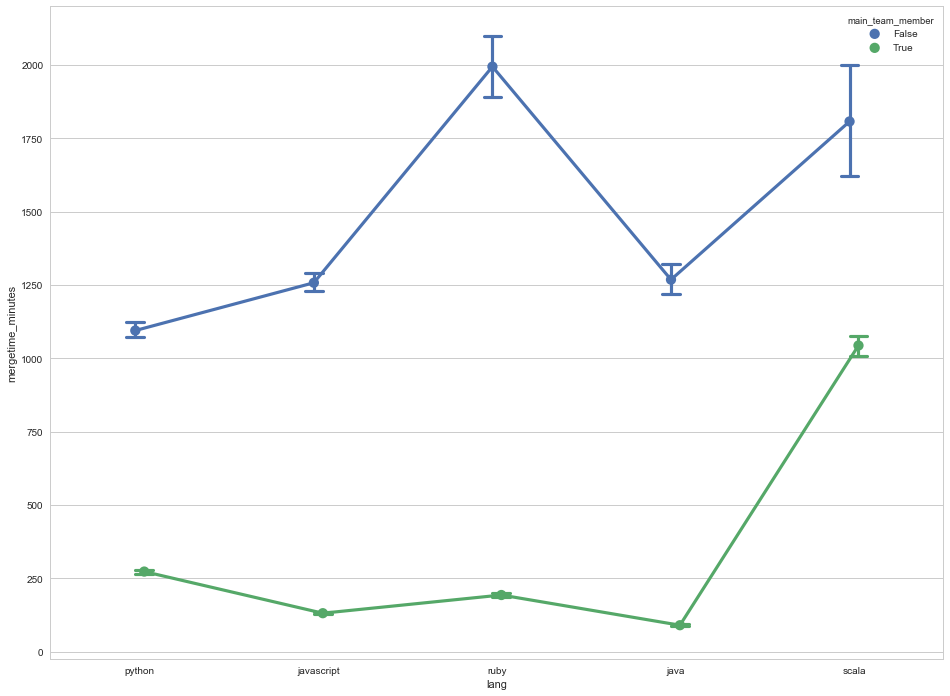

In [7]:
plt.figure(figsize=(16, 12))
ax = sns.pointplot(x="lang", y="mergetime_minutes", hue="main_team_member",# col="TargetType", #col="isOccluded",
                   data=alldata, dodge=True, estimator=np.median, capsize=.1)

# General Stats

In [7]:
alldata.describe()

,pull_req_id,github_id,created_at,merged_at,closed_at,lifetime_minutes,mergetime_minutes,description_length,num_commits,num_commits_open,num_pr_comments,num_issue_comments,num_commit_comments,num_comments,num_commit_comments_open,num_participants,files_added_open,files_deleted_open,files_modified_open,files_changed_open,src_files_open,doc_files_open,other_files_open,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,other_files,src_churn_open,test_churn_open,src_churn,test_churn,new_entropy,entropy_diff,commits_on_files_touched,commits_to_hottest_file,hotness,at_mentions_description,at_mentions_comments,perc_external_contribs,sloc,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,stars,team_size,workload,prev_pullreqs,requester_succ_rate,followers,prior_interaction_issue_events,prior_interaction_issue_comments,prior_interaction_pr_events,prior_interaction_pr_comments,prior_interaction_commits,prior_interaction_commit_comments,first_response,prior_interaction_comments,prior_interaction_events
count,9.160650e+05,916065.000000,9.160650e+05,7.774990e+05,9.160650e+05,9.160650e+05,7.774990e+05,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,9.160650e+05,9.160650e+05,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,9.160650e+05,916065.000000,916065.000000
mean,5.120390e+06,1070.437116,1.404434e+09,1.405751e+09,1.405623e+09,1.981375e+04,1.235726e+04,32.425654,4.214393,3.092552,1.053123,2.121589,0.154716,3.329427,0.036981,1.332705,1.945103,0.794075,4.675924,8.412869,4.736927,0.478345,1.728910,2.258986,0.975059,5.492707,8.726752,5.494127,0.548014,1.985052,222.789038,61.589729,271.746497,78.363710,41.842689,6.466938,35.729572,27.294291,0.091576,0.100776,0.669878,0.382609,3.139816e+04,2.729015e+03,74.759426,178.073513,1030.271484,21.718539,24.114887,42.724691,0.665418,64.041374,12.999204,44.484461,36.521675,16.356623,67.946030,1.649939,3.212295e+03,62.491023,117.466909
std,3.060346e+06,2713.290451,3.525084e+07,3.460269e+07,3.490052e+07,8.359596e+04,5.766905e+04,71.063246,15.025411,12.758104,5.741590,5.557046,3.122802,9.958141,2.441088,1.491926,37.780812,21.146356,42.917495,73.369825,32.296146,10.762261,49.457574,42.114321,25.036201,43.752540,76.356614,34.734139,12.041296,51.619940,1903.276720,618.295618,2207.778414,731.245105,238.265180,82.331530,91.788917,79.289543,0.649422,0.831911,2.670461,0.262618,4.694105e+05,9.088280e+04,1726.312648,2343.338954,2643.289017,42.163367,65.461755,101.226635,0.410933,406.091763,40.267169,127.647946,80.872466,55.431273,134.401776,16.890284,3.407224e+04,167.284946,223.491779
min,6.356000e+03,1.000000,1.275949e+09,1.276042e+09,1.275953e+09,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.155393e+06,0.000000,0.000000
25%,2.438854e+06,87.000000,1.382982e+09,1.384560e+09,1.384509e+09,2.600000e+01,2.100000e+01,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00

In [11]:
alldata["created_at"].max()

1448369704

In [16]:
alldata.groupby("project_name").describe()

asserts_per_kloc  \
                                                              count   
project_name                                                          
0xc0170/project_generator                                      53.0   
0xfe/vexflow                                                  152.0   
18F/C2                                                        750.0   
18F/analytics-reporter                                         50.0   
18F/control-masonry                                            53.0   
18F/data-act-pilot                                             75.0   
18F/federalist                                                105.0   
18F/foia                                                       87.0   
18F/open-data-maker                                           135.0   
18F/openFEC                                                   486.0   
2110215-ProgMeth-2015-1/2110215_Exercise0_Hello...             10.0   
23/resumable.js                                               105.0   
28msec/28                                                      63.0   
2gis/mapsapi                                                  237.0   
2gis/vmmaster                                                 145.0   
3dna/api_docs                                                  53.0   
4teamwork/ftw.contentpage                                     190.0   
4teamwork/ftw.upgrade                                          59.0   
4teamwork/ftw.workspace                                        52.0   
4teamwork/izug.ticketbox                                       66.0   
4teamwork/opengever.core                                      766.0   
52North/WPS                                                   105.0   
A24Group/ssGWT-lib                                            241.0   
AGILiDEE/dorsale                                               56.0   
ARM-software/trappy                                            42.0   
ARMmbed/yotta                                                 248.0   
ASPP/pelita                                                   150.0   
Aalk4308/Words                                                 71.0   
Abolitionist-Project/QuantiModo-WordPress-Plugin               93.0   
AccidentalOxidizer/Oxidizer                                   153.0   
...                                                             ...   
zenoss/ZenPacks.zenoss.Layer2                                 104.0   
zenoss/ZenPacks.zenoss.Microsoft.Windows                      438.0   
zenoss/ZenPacks.zenoss.OpenStackInfrastructure                180.0   
zenoss/txwinrm                                                 61.0   
zenoss/zenoss-zep                                              97.0   
zenoss/zenoss.metric.consumer                                  51.0   
zenoss/zenoss.toolbox                                          74.0   
zenoss/zenpacklib                                              81.0   
zephiK/android_packages_apps_settings                          46.0   
zeroclipboard/ZeroClipboard                                    56.0   
zeromq/jeromq                                                 142.0   
zeromq/jzmq                                                   184.0   
zeromq/pyzmq                                                  367.0   
zerovm/swift-browser                                           92.0   
zestsoftware/zest.releaser                                     64.0   
zettajs/zetta                                                 144.0   
zhuzhuor/Unblock-Youku                                         99.0   
zilkey/active_hash                                             44.0   
zkello/EECS314-BinaryFun                                       51.0   
zkoss/ztltest                                                 270.0   
zlsa/atc                                                      140.0   
zooniverse/Panoptes                                           777.0   
zopaUK/bozo-scripts                                            57.0   
zote

In [17]:
916065/166884

5.489232041417991

# RQ2 Lifecyle Characteristics

In [8]:
# Merge Statistics

In [9]:
mergeddata = (((alldata[['project_name', 'merged']][alldata.merged == True]).groupby(['project_name']).count()/
 alldata[['project_name', 'merged']].groupby(['project_name']).count()).sort_values('merged'))

In [10]:
mergeddata = mergeddata.reset_index()

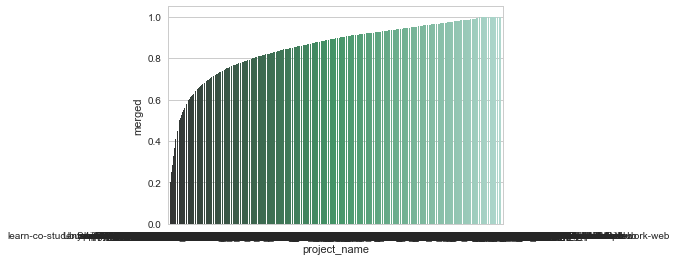

In [11]:
data = mergeddata
sns.barplot(x="project_name", y="merged", data=data, palette="BuGn_d")

## Test churn

In [9]:
alldata['churn_all'] = alldata.test_churn + alldata.src_churn
alldata.churn_all.quantile(q=[0.80, 0.90, 0.95])

0.80     169.0
0.90     480.0
0.95    1144.0
Name: churn_all, dtype: float64

In [10]:
#Churn
alldata.churn_all.mean()

350.11020724511906

In [11]:
alldata.churn_all.median()

20.0

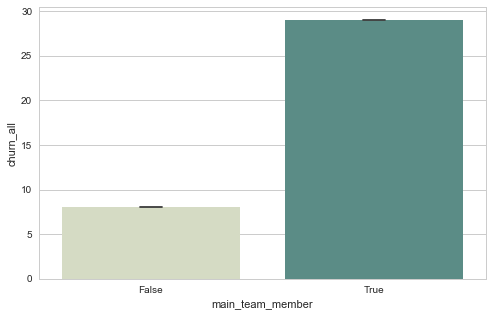

In [13]:
# Alldata excuding table
sns.set_style("whitegrid")
data = alldata
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="main_team_member", y="churn_all",# col="TargetType", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))


In [15]:
alldata[alldata.main_team_member = "True"].churn_all.median

SyntaxError: invalid syntax (<ipython-input-15-040b633339d2>, line 1)

# Pull Requests

In [13]:
## Group TargetTypes
alldata['mergetime_minutes_log'] = alldata['mergetime_minutes'].apply(
    lambda x: 
    math.log(float(x)) if x >= 1 else
    0
)
alldata['mergetime_minutes_log_bin'] = alldata['mergetime_minutes_log'].apply(
    lambda x: 
    0 if x != x else
    int(x) if x > 1 else
    int(x)
)

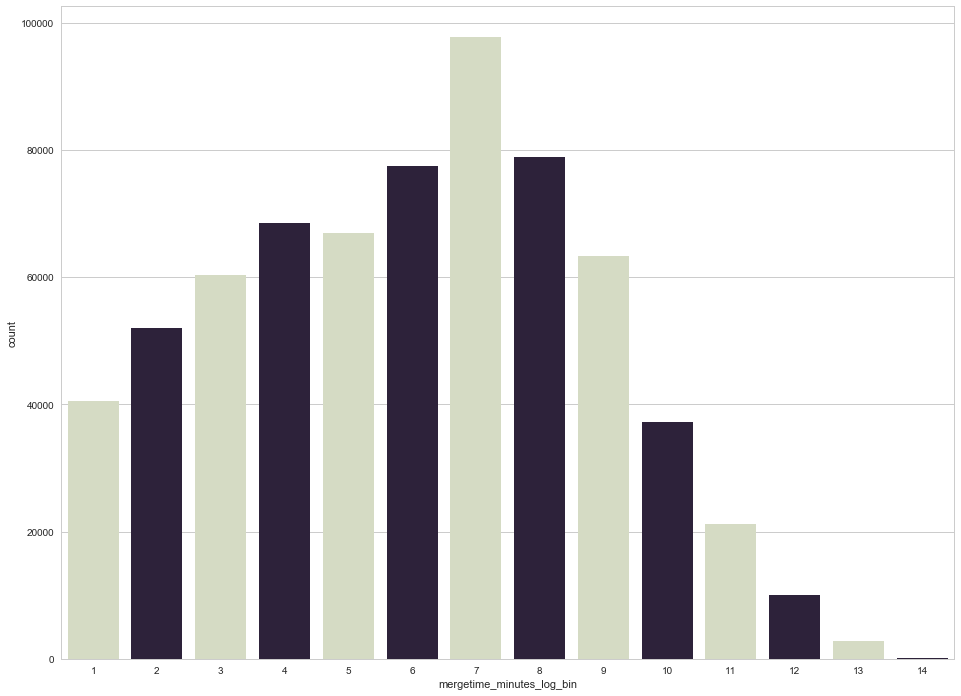

In [14]:
data = alldata[alldata.mergetime_minutes_log_bin >= 1]#[alldata.isOccluded == True]
plt.figure(figsize=(16, 12))
ax = sns.countplot(x="mergetime_minutes_log_bin", #hue="isOccluded", col="Condition",# col="TargetType",
                    palette=sns.cubehelix_palette(2, start=0.5, rot=-.75),
                   data=data)

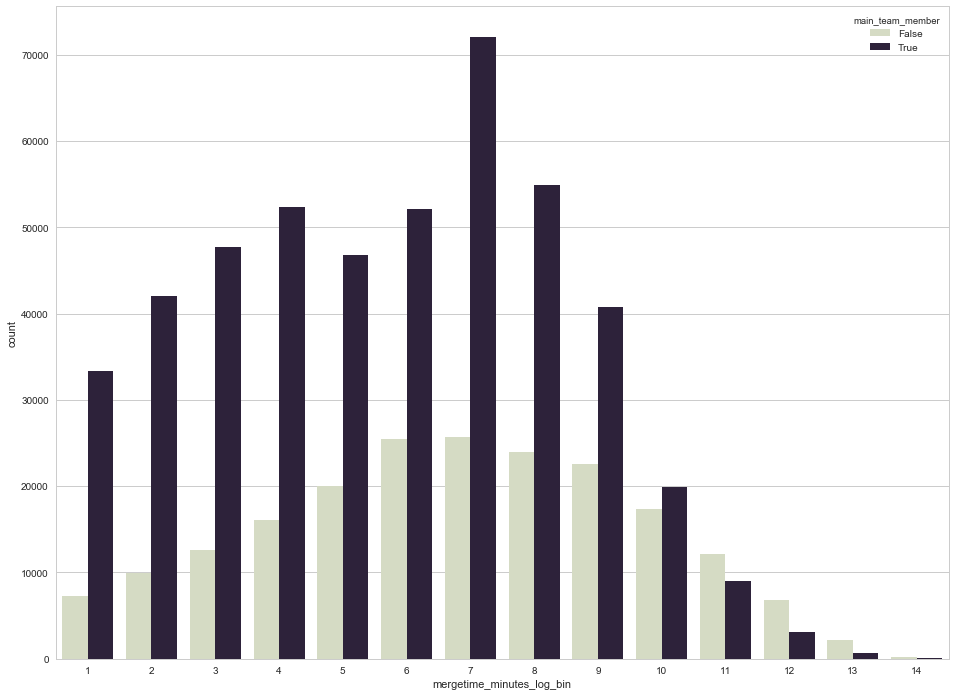

In [15]:
# With core team members
data = alldata[alldata.mergetime_minutes_log_bin >= 1]#[alldata.isOccluded == True]
plt.figure(figsize=(16, 12))
ax = sns.countplot(x="mergetime_minutes_log_bin", hue="main_team_member", #col="Condition",# col="TargetType",
                    palette=sns.cubehelix_palette(2, start=0.5, rot=-.75),
                   data=data)

## Lifetime of merged and unmerged pull requests

In [16]:
## Group TargetTypes
alldata['lifetime_minutes_log'] = alldata['lifetime_minutes'].apply(
    lambda x: 
    math.log(float(x)) if x >= 1 else
    0
)
alldata['lifetime_minutes_log_bin'] = alldata['lifetime_minutes_log'].apply(
    lambda x: 
    0 if x != x else
    int(x) if x > 1 else
    int(x)
)

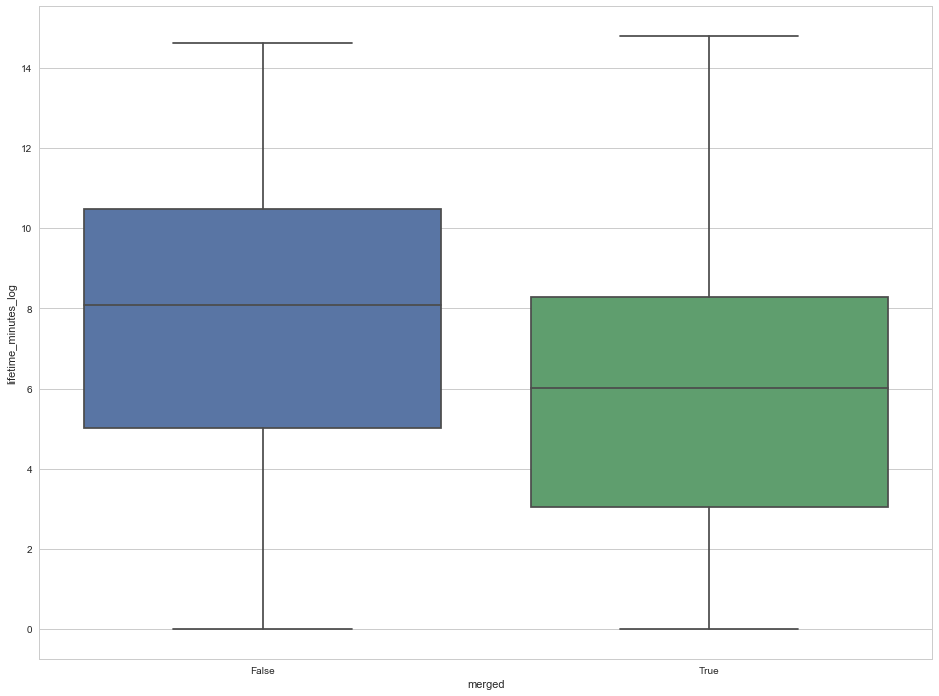

In [17]:
data=alldata
plt.figure(figsize=(16, 12))
sns.boxplot(x="merged", y="lifetime_minutes_log", data=data)

# Quantile ANalysis


In [30]:
alldata.describe()

,Unnamed: 0,pull_req_id,github_id,created_at,merged_at,closed_at,lifetime_minutes,mergetime_minutes,description_length,num_commits,num_commits_open,num_pr_comments,num_issue_comments,num_commit_comments,num_comments,num_commit_comments_open,num_participants,files_added_open,files_deleted_open,files_modified_open,files_changed_open,src_files_open,doc_files_open,other_files_open,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,other_files,src_churn_open,test_churn_open,src_churn,test_churn,new_entropy,entropy_diff,commits_on_files_touched,commits_to_hottest_file,hotness,at_mentions_description,at_mentions_comments,perc_external_contribs,sloc,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,stars,team_size,workload,prev_pullreqs,requester_succ_rate,followers,prior_interaction_issue_events,prior_interaction_issue_comments,prior_interaction_pr_events,prior_interaction_pr_comments,prior_interaction_commits,prior_interaction_commit_comments,first_response,prior_interaction_comments,prior_interaction_events,mergetime_minutes_log,mergetime_minutes_log_bin,lifetime_minutes_log,lifetime_minutes_log_bin
count,916065.000000,9.160650e+05,916065.000000,9.160650e+05,7.774990e+05,9.160650e+05,9.160650e+05,7.774990e+05,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,9.160650e+05,9.160650e+05,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,9.160650e+05,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000,916065.000000
mean,458033.000000,5.120390e+06,1070.437116,1.404434e+09,1.405751e+09,1.405623e+09,1.981375e+04,1.235726e+04,32.425654,4.214393,3.092552,1.053123,2.121589,0.154716,3.329427,0.036981,1.332705,1.945103,0.794075,4.675924,8.412869,4.736927,0.478345,1.728910,2.258986,0.975059,5.492707,8.726752,5.494127,0.548014,1.985052,222.789038,61.589729,271.746497,78.363710,41.842689,6.466938,35.729572,27.294291,0.091576,0.100776,0.669878,0.382609,3.139816e+04,2.729015e+03,74.759426,178.073513,1030.271484,21.718539,24.114887,42.724691,0.665418,64.041374,12.999204,44.484461,36.521675,16.356623,67.946030,1.649939,3.212295e+03,62.491023,117.466909,4.792067,4.417323,5.940764,5.494950
std,264445.331509,3.060346e+06,2713.290451,3.525084e+07,3.460269e+07,3.490052e+07,8.359596e+04,5.766905e+04,71.063246,15.025411,12.758104,5.741590,5.557046,3.122802,9.958141,2.441088,1.491926,37.780812,21.146356,42.917495,73.369825,32.296146,10.762261,49.457574,42.114321,25.036201,43.752540,76.356614,34.734139,12.041296,51.619940,1903.276720,618.295618,2207.778414,731.245105,238.265180,82.331530,91.788917,79.289543,0.649422,0.831911,2.670461,0.262618,4.694105e+05,9.088280e+04,1726.312648,2343.338954,2643.289017,42.163367,65.461755,101.226635,0.410933,406.091763,40.267169,127.647946,80.872466,55.431273,134.401776,16.890284,3.407224e+04,167.284946,223.491779,3.713054,3.567759,3.494680,3.421947
min,1.000000,6.356000e+03,1.000000,1.275949e+09,1.276042e+09,1.275953e+09,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [28]:
alldata["main_team_member"][alldata.main_team_member == True].count()

625760

In [29]:
alldata["main_team_member"][alldata.main_team_member == False].count()

290305

In [64]:
alldata["main_team_member"].count()

916065

## Number of Commits


In [20]:
alldata.num_commits.quantile(q=[0.80, 0.90, 0.95])

0.80     4.0
0.90     7.0
0.95    13.0
Name: num_commits, dtype: float64

In [21]:
alldata[alldata.main_team_member == True].num_commits.quantile(q=[0.80, 0.90, 0.95])

0.80     4.0
0.90     8.0
0.95    15.0
Name: num_commits, dtype: float64

In [22]:
alldata[alldata.main_team_member == False].num_commits.quantile(q=[0.80, 0.90, 0.95])

0.80    3.0
0.90    5.0
0.95    8.0
Name: num_commits, dtype: float64

## Files Changed

In [23]:
alldata.files_changed.quantile(q=[0.80, 0.90, 0.95])

0.80     6.0
0.90    13.0
0.95    25.0
Name: files_changed, dtype: float64

In [24]:
alldata[alldata.main_team_member == True].files_changed.quantile(q=[0.80, 0.90, 0.95])

0.80     8.0
0.90    16.0
0.95    31.0
Name: files_changed, dtype: float64

In [31]:
alldata[alldata.main_team_member == False].files_changed.quantile(q=[0.80, 0.90, 0.95])

0.80     4.0
0.90     7.0
0.95    14.0
Name: files_changed, dtype: float64

## Test churn

In [32]:
alldata['churn_all'] = alldata.test_churn + alldata.src_churn
alldata.churn_all.quantile(q=[0.80, 0.90, 0.95])

0.80     169.0
0.90     480.0
0.95    1144.0
Name: churn_all, dtype: float64

In [33]:
alldata[alldata.main_team_member == True].churn_all.quantile(q=[0.80, 0.90, 0.95])

0.80     226.0
0.90     615.0
0.95    1415.0
Name: churn_all, dtype: float64

In [34]:
alldata[alldata.main_team_member == False].churn_all.quantile(q=[0.80, 0.90, 0.95])

0.80     75.0
0.90    221.0
0.95    556.0
Name: churn_all, dtype: float64

In [35]:
alldata.churn_all.mean()

350.11020724511906

In [16]:
alldata[alldata.main_team_member == True].churn_all.median()

29.0

In [17]:
alldata[alldata.main_team_member == False].churn_all.median()

8.0

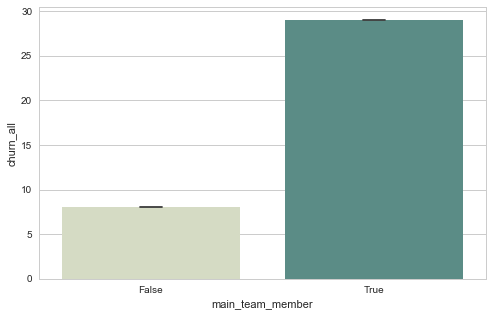

In [38]:
# Alldata excuding table
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="main_team_member", y="churn_all",# col="TargetType", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))

# # Axis
# ax.set(xlabel='Technique', ylabel='MT')

# groupedCondtion = alldata[["Condition", "TotalTime"]].groupby("Condition").median()
# print(groupedCondtion)

## Merge Time

In [18]:
alldata.mergetime_minutes.quantile(q=[0.05, 0.25, 0.50, 0.65 ,0.80, 0.90, 0.95])

0.05        0.0
0.25       21.0
0.50      403.0
0.65     1440.0
0.80     6038.0
0.90    19793.0
0.95    50625.2
Name: mergetime_minutes, dtype: float64

In [21]:
alldata.mergetime_minutes.median()

403.0

In [22]:
alldata.mergetime_minutes.mean()

12357.26484407054

In [29]:
less_day = alldata[alldata.mergetime_minutes <= 1440].pull_req_id.count()
total_day = alldata.pull_req_id.count()
less_day/total_day

0.55170211720784001

In [19]:
alldata[alldata.main_team_member == True].mergetime_minutes.quantile(q=[0.05, 0.25, 0.50, 0.69 ,0.80, 0.90, 0.95])

0.05        0.0
0.25       11.0
0.50      201.0
0.69     1367.0
0.80     4071.0
0.90    11052.0
0.95    26314.2
Name: mergetime_minutes, dtype: float64

In [23]:
alldata[alldata.main_team_member == True].mergetime_minutes.median()

201.0

In [24]:
alldata[alldata.main_team_member == True].mergetime_minutes.mean()

6756.8891393908225

In [33]:
less_day = alldata.query("mergetime_minutes <= 1440 and main_team_member == True").pull_req_id.count()
total_day = alldata[alldata.main_team_member == True].pull_req_id.count()
less_day/total_day

0.63588756072615704

In [20]:
alldata[alldata.main_team_member == False].mergetime_minutes.quantile(q=[0.05, 0.25, 0.50, 0.63 ,0.80, 0.90, 0.95])

0.05         4.00
0.25       141.00
0.50      1326.00
0.63      4155.00
0.80     18944.20
0.90     61182.20
0.95    142354.65
Name: mergetime_minutes, dtype: float64

In [25]:
alldata[alldata.main_team_member == False].mergetime_minutes.median()

1326.0

In [26]:
alldata[alldata.main_team_member == False].mergetime_minutes.mean()

27516.300390941597

In [36]:
less_day = alldata.query("mergetime_minutes <= 1440 and main_team_member == False").pull_req_id.count()
total_day = alldata[alldata.main_team_member == False].pull_req_id.count()
less_day/total_day

0.37023819775753086

### Tests Mann Whitney

In [37]:
data_members = alldata[alldata.main_team_member == True]
data_non = alldata[alldata.main_team_member == False]
stats.mannwhitneyu(data_members.mergetime_minutes, data_non.mergetime_minutes)

MannwhitneyuResult(statistic=54998662284.0, pvalue=0.0)

## Number of Comments


In [38]:
alldata.num_comments.mean()

3.3294274969570936

In [43]:
alldata[alldata.main_team_member == True].num_comments.mean()

3.5249840194323703

In [44]:
alldata[alldata.main_team_member == False].num_comments.mean()

2.9079003117410998

In [41]:
alldata[alldata.main_team_member == False].num_comments.quantile(q=[0.05, 0.25, 0.50, 0.60 ,0.80, 0.90, 0.95])

0.05     0.0
0.25     0.0
0.50     1.0
0.60     1.0
0.80     4.0
0.90     7.0
0.95    12.0
Name: num_comments, dtype: float64

In [47]:
alldata[alldata.main_team_member == True].num_comments.quantile(q=[0.05, 0.25, 0.50, 0.60 ,0.80, 0.90, 0.95])

0.05     0.0
0.25     0.0
0.50     1.0
0.60     1.0
0.80     4.0
0.90     9.0
0.95    15.0
Name: num_comments, dtype: float64

## Test Code analysis

In [11]:
## Group TargetTypes
alldata['test_cases_presented'] = alldata['test_churn'].apply(
    lambda x: 
    True if x > 0 else
    False
)

In [49]:
print(alldata[alldata.test_churn == 0]['pull_req_id'].count())
print(alldata[alldata.test_churn > 0]['pull_req_id'].count())

632478
283587


In [50]:
alldata[alldata.test_churn > 0].mergetime_minutes.mean()

15180.023170935605

In [51]:
alldata[alldata.test_churn == 0].mergetime_minutes.mean()

11056.817296600648

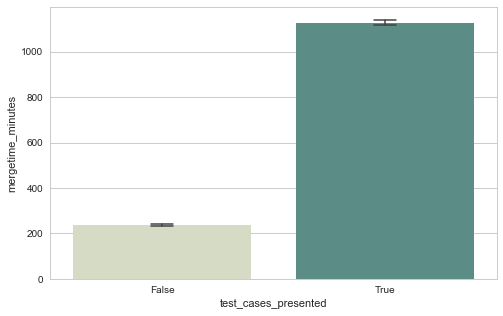

In [67]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="test_cases_presented", y="mergetime_minutes", #hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))


In [72]:
alldata[alldata.test_cases_presented == True].mergetime_minutes.median()

1128.0

In [73]:
alldata[alldata.test_cases_presented == False].mergetime_minutes.median()

236.0

In [69]:
alldata[alldata.test_cases_presented == True].num_comments.count()

283587

In [70]:
alldata[alldata.test_cases_presented == False].num_comments.count()

632478

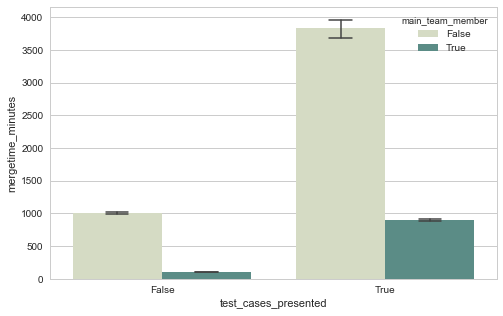

In [47]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="test_cases_presented", y="mergetime_minutes", hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))



In [55]:
megeTime_FF = alldata.query("test_cases_presented == False and main_team_member == False").mergetime_minutes.median()
megeTime_TF = alldata.query("test_cases_presented == True and main_team_member == False").mergetime_minutes.median()
megeTime_FT = alldata.query("test_cases_presented == False and main_team_member == True").mergetime_minutes.median()
megeTime_TT = alldata.query("test_cases_presented == True and main_team_member == True").mergetime_minutes.median()

print("MergeTime: TestCases=F, TeamMember=F --\t {}".format(megeTime_FF))
print("MergeTime: TestCases=T, TeamMember=F --\t {}".format(megeTime_TF))
print("MergeTime: TestCases=F, TeamMember=T --\t {}".format(megeTime_FT))
print("MergeTime: TestCases=T, TeamMember=T --\t {}".format(megeTime_TT))

MergeTime: TestCases=F, TeamMember=F --	 1008.5
MergeTime: TestCases=T, TeamMember=F --	 3831.5
MergeTime: TestCases=F, TeamMember=T --	 103.0
MergeTime: TestCases=T, TeamMember=T --	 899.0


In [48]:
data=alldata[alldata.merged == True]
stats.mannwhitneyu(data.test_cases_presented, data.mergetime_minutes)

MannwhitneyuResult(statistic=38093471144.0, pvalue=0.0)

# Core-Team Membership Analysis

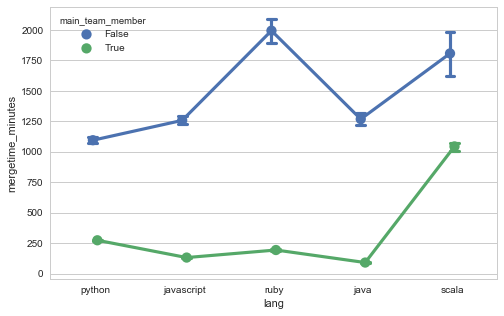

In [9]:
plt.figure(figsize=(8, 5))
ax = sns.pointplot(x="lang", y="mergetime_minutes", hue="main_team_member",# col="TargetType", #col="isOccluded",
                   data=alldata, dodge=True, estimator=np.median, capsize=.1)

## Merge Time by Team Membership

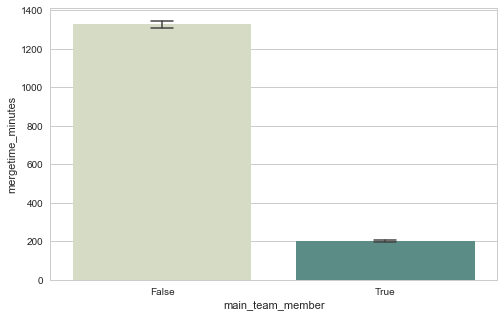

In [12]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="main_team_member", y="mergetime_minutes", #hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))


In [16]:
data=alldata[alldata.merged == True]
print(data.query("main_team_member == True").mergetime_minutes.median())
print(data.query("main_team_member == False").mergetime_minutes.median())
print(data.query("main_team_member == True").mergetime_minutes.mean())
print(data.query("main_team_member == False").mergetime_minutes.mean())

201.0
1326.0
6756.88913939
27516.3003909


In [19]:
data=alldata[alldata.merged == True]
stats.mannwhitneyu(data[data.main_team_member == True].mergetime_minutes, data[data.main_team_member == False].mergetime_minutes)

MannwhitneyuResult(statistic=40750525867.0, pvalue=0.0)

In [21]:
data=alldata[alldata.merged == True]
data[data.main_team_member == False].mergetime_minutes.std()

93400.657942969527

## Merge Time by Team Membership and Test cases

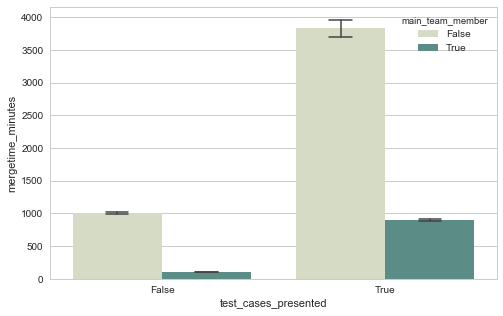

In [54]:
# Alldata excuding table
data=alldata#[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="test_cases_presented", y="mergetime_minutes", hue="main_team_member", #col="merged",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))

## Merge Time by Team Membership and CI usage

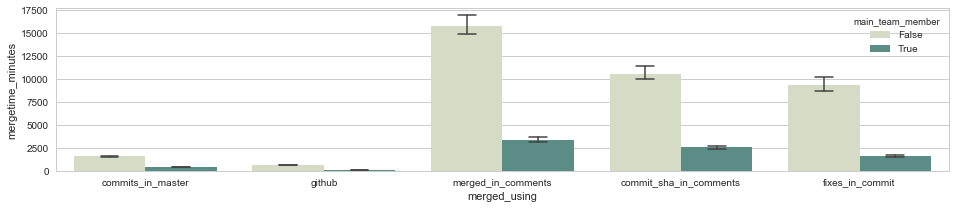

In [6]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(16, 3))
ax = sns.barplot(x="merged_using", y="mergetime_minutes", hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))


## Merge Time by Team Membership and Language

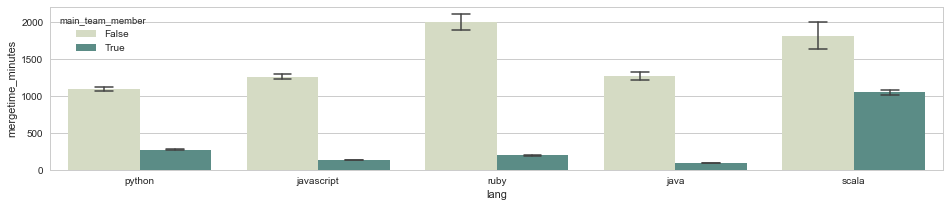

In [56]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(16, 3))
ax = sns.barplot(x="lang", y="mergetime_minutes", hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))

## Merge Time by Language

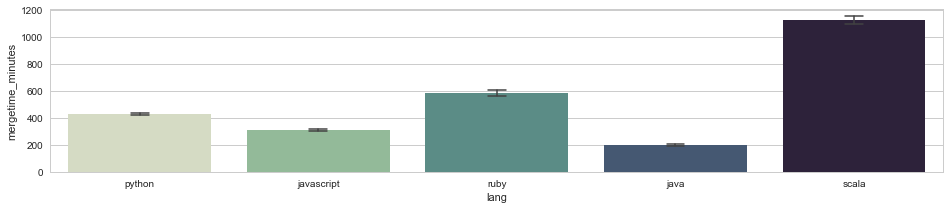

In [7]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(16, 3))
ax = sns.barplot(x="lang", y="mergetime_minutes",# hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(5, start=0.5, rot=-.75))

In [58]:
data=alldata[alldata.merged == True]
data=data[data.main_team_member == False]
print("Scala", data[data.lang == "scala"].mergetime_minutes.median())
print("Python", data[data.lang == "python"].mergetime_minutes.median())
print("Ruby", data[data.lang == "ruby"].mergetime_minutes.median())
print("Java", data[data.lang == "java"].mergetime_minutes.median())
print("Javascript", data[data.lang == "javascript"].mergetime_minutes.median())

Scala 1808.0
Python 1095.0
Ruby 1995.0
Java 1268.5
Javascript 1258.0


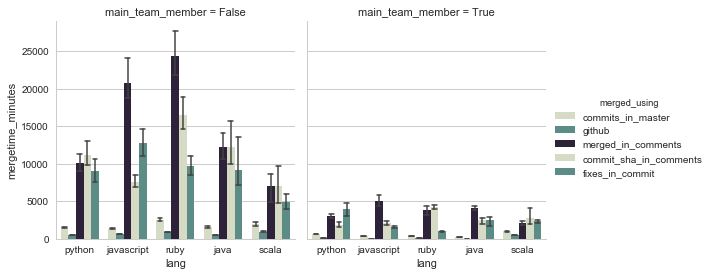

In [61]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
sns.factorplot(x="lang", y="mergetime_minutes", hue="merged_using", col="main_team_member",
                   data=data, dodge=True, estimator=np.median, kind="bar",
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))

In [ ]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set(font_scale=5)
sns.set_style("whitegrid")
plt.figure(figsize=(20, 20))
sns.factorplot(x="lang", y="mergetime_minutes", hue="main_team_member", col="test_cases_presented",
                   data=data, dodge=True, estimator=np.median, kind="bar", size=10,
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))

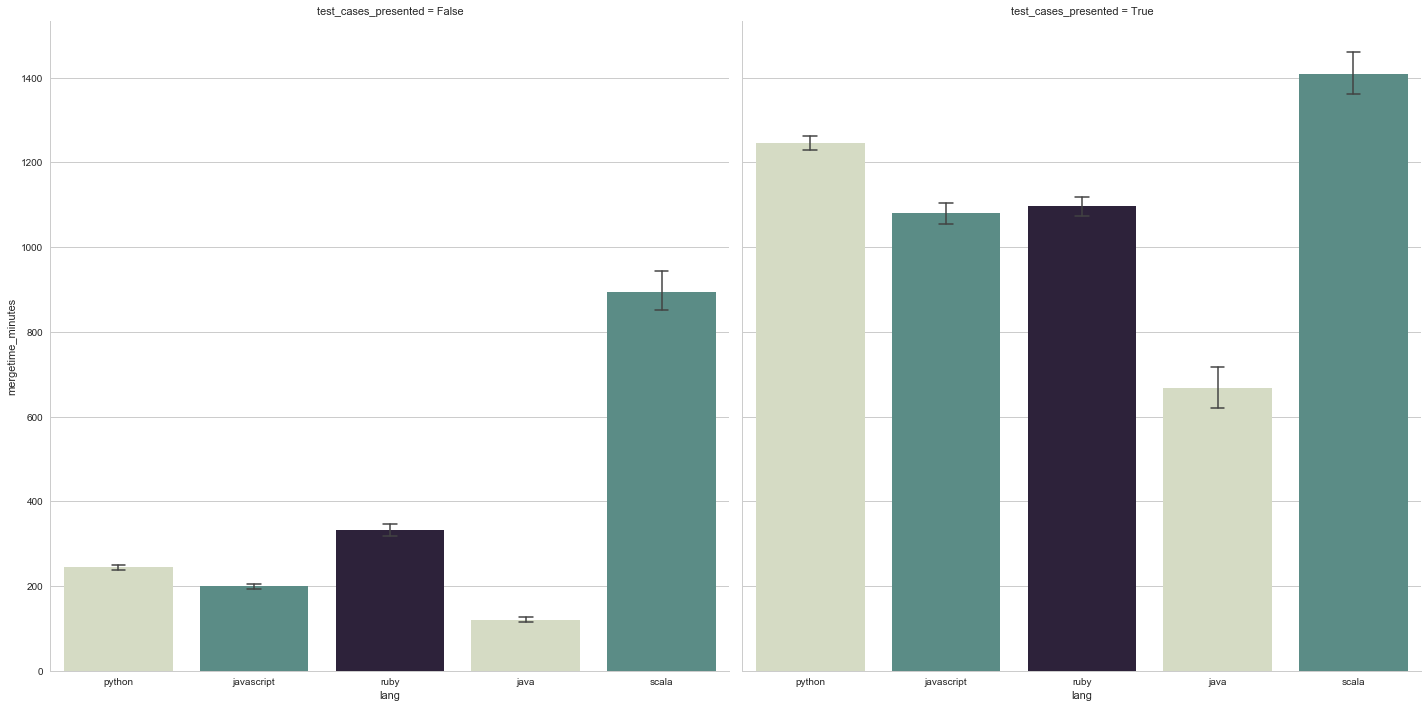

In [77]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(20, 20))
sns.factorplot(x="lang", y="mergetime_minutes", col="test_cases_presented",
                   data=data, dodge=True, estimator=np.median, kind="bar", size=10,
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))

## CI INtegration

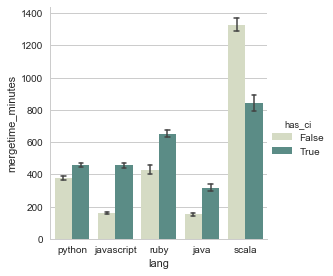

In [63]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(10, 16))
sns.factorplot(x="lang", y="mergetime_minutes", hue="has_ci",  #col="main_team_member",
                   data=data, dodge=True, estimator=np.median, kind="bar",
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))

# Scrap Data

In [6]:
alldata

,Unnamed: 0,pull_req_id,project_name,lang,github_id,created_at,merged_at,closed_at,lifetime_minutes,mergetime_minutes,merged_using,conflict,forward_links,intra_branch,description_length,num_commits,num_commits_open,num_pr_comments,num_issue_comments,num_commit_comments,num_comments,num_commit_comments_open,num_participants,files_added_open,files_deleted_open,files_modified_open,files_changed_open,src_files_open,doc_files_open,other_files_open,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,other_files,src_churn_open,test_churn_open,src_churn,test_churn,new_entropy,entropy_diff,commits_on_files_touched,commits_to_hottest_file,hotness,at_mentions_description,at_mentions_comments,perc_external_contribs,sloc,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,stars,team_size,workload,ci,requester,closer,merger,prev_pullreqs,requester_succ_rate,followers,main_team_member,social_connection,prior_interaction_issue_events,prior_interaction_issue_comments,prior_interaction_pr_events,prior_interaction_pr_comments,prior_interaction_commits,prior_interaction_commit_comments,first_response,prior_interaction_comments,prior_interaction_events,has_ci,merged
0,1,7120440,0xc0170/project_generator,python,114,1429122592,1.429130e+09,1429130095,125,125.0,commits_in_master,False,False,True,19,4,2,0,0,0,0,0,0,0,0,5,6,5,0,0,0,0,6,6,6,0,0,20,0,41,0,23.027030,9.643052,65,33,0.103586,0,0,0.187251,1506,2.656042,0.000000,0.000000,9,2,1,travis,0xc0170,0xc0170,0xc0170,19,0.947368,43,True,False,31,128,48,6,196,0,-1,134,275,True,True
1,2,7118732,0xc0170/project_generator,python,113,1429115903,1.429116e+09,1429115937,0,0.0,commits_in_master,False,False,True,21,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,6,0,6,0,4.454677,1.865147,13,13,0.052632,0,0,0.182186,1506,2.656042,0.000000,0.000000,9,2,2,travis,0xc0170,0xc0170,0xc0170,18,0.944444,43,True,False,31,126,45,6,192,0,-1,132,268,True,True
2,3,7068246,0xc0170/project_generator,python,112,1428848545,1.429120e+09,1429119602,4517,4517.0,commits_in_master,False,False,True,6,2,2,0,2,0,2,0,1,0,0,1,1,1,0,0,0,0,1,1,1,0,0,18,0,18,0,8.383085,3.509948,13,13,0.053279,0,0,0.176230,1506,2.656042,0.000000,0.000000,9,2,1,travis,0xc0170,0xc0170,0xc0170,17,0.941176,43,True,False,31,121,44,6,189,0,22,127,264,True,True
3,4,7067381,0xc0170/project_generator,python,110,1428841052,1.428841e+09,1428841169,1,1.0,commits_in_master,False,False,True,14,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,2,0,2,0,4.410999,1.846861,8,8,0.033755,0,0,0.164557,1504,2.659574,0.000000,0.000000,9,2,2,travis,0xc0170,0xc0170,0xc0170,16,0.937500,43,True,False,30,118,41,6,182,0,-1,124,253,True,True
4,5,7057359,0xc0170/project_generator,python,108,1428739984,NaN,1428846135,1769,NaN,unknown,False,False,True,20,3,1,0,4,0,4,0,2,0,0,1,2,1,0,0,0,0,2,2,2,0,0,5,0,18,0,4.334749,1.814936,13,13,0.055319,0,0,0.165957,1504,2.659574,0.000000,0.000000,9,2,1,travis,0xc0170,0xc0170,NaN,15,1.000000,43,True,False,29,116,40,6,180,0,254,122,249,True,False
5,6,7043309,0xc0170/project_generator,python,106,1428659223,1.428736e+09,1428736138,1281,1281.0,commits_in_master,False,False,True,28,3,1,0,1,0,1,0,1,0,0,2,3,1,0,1,0,0,3,3,2,0,1,4,0,19,0,8.548904,3.577787,16,10,0.043478,0,0,0.160870,1500,2.666667,0.000000,0.000000,9,2,2,travis,0xc0170,0xc0170,0xc0170,14,1.000000,42,True,False,28,113,37,6,175,0,1281,119,240,True,True
6,7,7032619,0xc0170/project_generator,python,104,1428597466,1.428736e+09,1428736190,2312,2312.0,commits_in_master,False,False,True,12,1,1,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,4,4,4,0,0,23,0,23,0,17.787228,7.444101,36,23,0.069869,0,0,0.161572,1500,2.666667,0.000000,0.000000,9,2,1,travis,0xc0170,0xc0170,0xc0170,13,1.000000,42,True,False,27,113,36,6,174,0,-1,119,237,True,True
7,8,6995256,0xc0170/project_generator,python,102,1428423121,1.428425e+09,1428424525,23,23.0,commits_in_master,False,False,True,322,1,1,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,4,4,4,0,0,10,0,10,0,17.907576,7.494324,53,27,0.108108,0,0,0.139640,1488,2.688172,0.000000,0.000000,9,2,1,travi

In [7]:
alldata.loc[:,['lifetime_minutes', 'mergetime_minutes', 'merged_using', 'conflict',
       'forward_links', 'team_size', 'num_commits', 'num_comments',
       'files_changed', 'perc_external_contribs', 'sloc', 'src_churn',
       'test_churn', 'commits_on_files_touched', 'test_lines_per_kloc',
       'test_cases_per_kloc', 'asserts_per_kloc', 'watchers', 'requester',
       'prev_pullreqs', 'requester_succ_rate', 'followers', 'intra_branch',
       'main_team_member', 'merged']]

,lifetime_minutes,mergetime_minutes,merged_using,conflict,forward_links,team_size,num_commits,num_comments,files_changed,perc_external_contribs,sloc,src_churn,test_churn,commits_on_files_touched,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,watchers,requester,prev_pullreqs,requester_succ_rate,followers,intra_branch,main_team_member,merged
0,125,125.0,commits_in_master,False,False,2,4,0,6,0.187251,1506,41,0,65,2.656042,0.000000,0.000000,NaN,0xc0170,19,0.947368,43,True,True,True
1,0,0.0,commits_in_master,False,False,2,1,0,1,0.182186,1506,6,0,13,2.656042,0.000000,0.000000,NaN,0xc0170,18,0.944444,43,True,True,True
2,4517,4517.0,commits_in_master,False,False,2,2,2,1,0.176230,1506,18,0,13,2.656042,0.000000,0.000000,NaN,0xc0170,17,0.941176,43,True,True,True
3,1,1.0,commits_in_master,False,False,2,1,0,1,0.164557,1504,2,0,8,2.659574,0.000000,0.000000,NaN,0xc0170,16,0.937500,43,True,True,True
4,1769,NaN,unknown,False,False,2,3,4,2,0.165957,1504,18,0,13,2.659574,0.000000,0.000000,NaN,0xc0170,15,1.000000,43,True,True,False
5,1281,1281.0,commits_in_master,False,False,2,3,1,3,0.160870,1500,19,0,16,2.666667,0.000000,0.000000,NaN,0xc0170,14,1.000000,42,True,True,True
6,2312,2312.0,commits_in_master,False,False,2,1,0,4,0.161572,1500,23,0,36,2.666667,0.000000,0.000000,NaN,0xc0170,13,1.000000,42,True,True,True
7,23,23.0,commits_in_master,False,False,2,1,0,4,0.139640,1488,10,0,53,2.688172,0.000000,0.000000,NaN,0xc0170,12,1.000000,42,True,True,True
8,976,976.0,commits_in_master,False,False,2,1,0,2,0.136364,1484,8,0,24,2.695418,0.000000,0.000000,NaN,sg-,8,0.875000,15,False,False,True
9,31,31.0,commits_in_master,False,False,2,1,0,1,0.133028,1484,0,0,3,2.695418,0.000000,0.000000,NaN,sg-,7,0.857143,15,False,False,True


In [12]:
alldata

,pull_req_id,project_name,lang,github_id,created_at,merged_at,closed_at,lifetime_minutes,mergetime_minutes,merged_using,conflict,forward_links,intra_branch,description_length,num_commits,num_commits_open,num_pr_comments,num_issue_comments,num_commit_comments,num_comments,num_commit_comments_open,num_participants,files_added_open,files_deleted_open,files_modified_open,files_changed_open,src_files_open,doc_files_open,other_files_open,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,other_files,src_churn_open,test_churn_open,src_churn,test_churn,new_entropy,entropy_diff,commits_on_files_touched,commits_to_hottest_file,hotness,at_mentions_description,at_mentions_comments,perc_external_contribs,sloc,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,stars,team_size,workload,ci,requester,closer,merger,prev_pullreqs,requester_succ_rate,followers,main_team_member,social_connection,prior_interaction_issue_events,prior_interaction_issue_comments,prior_interaction_pr_events,prior_interaction_pr_comments,prior_interaction_commits,prior_interaction_commit_comments,first_response,prior_interaction_comments,prior_interaction_events,has_ci,merged
0,7120440,0xc0170/project_generator,python,114,1429122592,1.429130e+09,1429130095,125,125.0,commits_in_master,False,False,True,19,4,2,0,0,0,0,0,0,0,0,5,6,5,0,0,0,0,6,6,6,0,0,20,0,41,0,23.027030,9.643052,65,33,0.103586,0,0,0.187251,1506,2.656042,0.000000,0.000000,9,2,1,travis,0xc0170,0xc0170,0xc0170,19,0.947368,43,True,False,31,128,48,6,196,0,-1,134,275,True,True
1,7118732,0xc0170/project_generator,python,113,1429115903,1.429116e+09,1429115937,0,0.0,commits_in_master,False,False,True,21,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,6,0,6,0,4.454677,1.865147,13,13,0.052632,0,0,0.182186,1506,2.656042,0.000000,0.000000,9,2,2,travis,0xc0170,0xc0170,0xc0170,18,0.944444,43,True,False,31,126,45,6,192,0,-1,132,268,True,True
2,7068246,0xc0170/project_generator,python,112,1428848545,1.429120e+09,1429119602,4517,4517.0,commits_in_master,False,False,True,6,2,2,0,2,0,2,0,1,0,0,1,1,1,0,0,0,0,1,1,1,0,0,18,0,18,0,8.383085,3.509948,13,13,0.053279,0,0,0.176230,1506,2.656042,0.000000,0.000000,9,2,1,travis,0xc0170,0xc0170,0xc0170,17,0.941176,43,True,False,31,121,44,6,189,0,22,127,264,True,True
3,7067381,0xc0170/project_generator,python,110,1428841052,1.428841e+09,1428841169,1,1.0,commits_in_master,False,False,True,14,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,2,0,2,0,4.410999,1.846861,8,8,0.033755,0,0,0.164557,1504,2.659574,0.000000,0.000000,9,2,2,travis,0xc0170,0xc0170,0xc0170,16,0.937500,43,True,False,30,118,41,6,182,0,-1,124,253,True,True
4,7057359,0xc0170/project_generator,python,108,1428739984,NaN,1428846135,1769,NaN,unknown,False,False,True,20,3,1,0,4,0,4,0,2,0,0,1,2,1,0,0,0,0,2,2,2,0,0,5,0,18,0,4.334749,1.814936,13,13,0.055319,0,0,0.165957,1504,2.659574,0.000000,0.000000,9,2,1,travis,0xc0170,0xc0170,NaN,15,1.000000,43,True,False,29,116,40,6,180,0,254,122,249,True,False
5,7043309,0xc0170/project_generator,python,106,1428659223,1.428736e+09,1428736138,1281,1281.0,commits_in_master,False,False,True,28,3,1,0,1,0,1,0,1,0,0,2,3,1,0,1,0,0,3,3,2,0,1,4,0,19,0,8.548904,3.577787,16,10,0.043478,0,0,0.160870,1500,2.666667,0.000000,0.000000,9,2,2,travis,0xc0170,0xc0170,0xc0170,14,1.000000,42,True,False,28,113,37,6,175,0,1281,119,240,True,True
6,7032619,0xc0170/project_generator,python,104,1428597466,1.428736e+09,1428736190,2312,2312.0,commits_in_master,False,False,True,12,1,1,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,4,4,4,0,0,23,0,23,0,17.787228,7.444101,36,23,0.069869,0,0,0.161572,1500,2.666667,0.000000,0.000000,9,2,1,travis,0xc0170,0xc0170,0xc0170,13,1.000000,42,True,False,27,113,36,6,174,0,-1,119,237,True,True
7,6995256,0xc0170/project_generator,python,102,1428423121,1.428425e+09,1428424525,23,23.0,commits_in_master,False,False,True,322,1,1,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,4,4,4,0,0,10,0,10,0,17.907576,7.494324,53,27,0.108108,0,0,0.139640,1488,2.688172,0.000000,0.000000,9,2,1,travis,0xc0170,0xc0170,0xc0170,1